# **Generalised SIAM URG**

In [323]:
import itertools
from tqdm.autonotebook import tqdm
from time import sleep
from math import sqrt
from multiprocessing import Pool
from itertools import product, repeat
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from qutip import *
from scipy.signal import peak_widths
from scipy.optimize import curve_fit
from functools import partial
import warnings
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh
import numpy.linalg
import os, sys
from scipy.signal import savgol_filter
from os import devnull
import matplotlib.animation as animation
import pickle

plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'lightgray'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams["figure.autolayout"] = 'True'
plt.rcParams['axes.xmargin'] = 0.02
plt.rcParams['axes.ymargin'] = 0.02
plt.rc('legend',fontsize='large')
plt.rcParams['axes.grid'] = False
mpl.rcParams['lines.markersize'] = 10
font = {'size'   : 35}
mpl.rc('font', **font)
mpl.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{amsmath,nicefrac,braket}')
plt.rcParams["figure.figsize"]= 11, 8
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["legend.framealpha"] = 0.4
mpl.rcParams["legend.handletextpad"] = 0.2
mpl.rcParams["legend.edgecolor"] = "black"
mpl.rcParams["legend.handlelength"] = 1
mpl.rcParams["legend.labelspacing"] = 0
cols = [p['color'] for p in plt.rcParams['axes.prop_cycle'][:6]]


def qload(name):
    fileObject = open(name + '.qu', 'rb')  # open the file for reading
    out = pickle.load(fileObject)  # return the object from the file
    return out


deltaD = 0.05
rho = 2/deltaD
nj = rho*deltaD

corr_folder = './corr_data/'
fig_folder = './figs/'
lfl_wf_folder = './wfs_for_entanglement/'

for folder in (corr_folder, fig_folder, lfl_wf_folder):
    if not os.path.exists(folder): os.mkdir(folder)

## RG equations and denominators

In [278]:
def den(w, D, U, J, K, Ub=0):
    d0 = w - D/2 + Ub/4 - U/2 + K/4
    d1 = w - D/2 + Ub/4 + U/2 + J/4
    d2 = w - D/2 + Ub/4 + J/4
    d3 = w - D/2 + Ub/4 + K/4
    return np.array([d0, d1, d2, d3])

In [279]:
def rg1(w, D, U, V, J, Ub=0):
    K = 0
    d0,d1,d2,d3 = den(w, D, U, J, K, Ub=Ub)
    deltaU = 4*V**2*nj*(1/d1 - 1/d0) - nj*J**2/(2*d2) if d1 < 0 else 0
    deltaV = -nj*(V/8)*((3*J + 4*Ub)*(1/d1 + 1/d2) + 4*Ub*(1/d0 + 1/d3)) if d1 < 0 else 0
    deltaJ = -nj*(J**2 + 4*J*Ub)/d2 if d2 < 0 else 0

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    J = 0 if (J + deltaJ) * J <= 0 else J + deltaJ

    return U, V, J

## RG flow implementation

In [280]:
def complete_RG(w, D0, U0, V0, J0, Ub=0):
    d1 = den(w, D0, U0, J0, 0, Ub=Ub)[1]
    assert d1 < 0
    U = [U0]
    V = [V0]
    J = [J0]
    E = [D0]
    for D in np.arange(D0, 0, -deltaD):
        U_j, V_j, J_j = rg1(w, D, U[-1], V[-1], J[-1], Ub=Ub)
        U.append(U_j)
        V.append(V_j)
        J.append(J_j)
        E.append(D - deltaD)
        d0,d1,d2,d3 = den(w, E[-1], U[-1], J[-1], 0, Ub=Ub)
        if d1 >= 0 and d2 >= 0:
            break
        
    return np.array(E), np.array(U), np.array(V), np.array(J)

## Create real space and $k-$space Hamiltonians

In [281]:
def get_full_ham(t, lattice_dim, U, V, J, Ubath=0):
    imp_length = 1
    total_dim = 2*(imp_length + lattice_dim)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    
    Sz_imp = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
    Sp_imp = c_all[0].dag()*c_all[1]
    Sm_imp = Sp_imp.dag()
    Sz_bath = 0.5 * (c_all[2].dag()*c_all[2] - c_all[3].dag()*c_all[3])
    Sp_bath = c_all[2].dag()*c_all[3]
    Sm_bath = Sp_bath.dag()
    
    H_U = (-U*2) * Sz_imp**2
    H_Ubath = -(Ubath*4) * Sz_bath**2 
    H_V = V * (c_all[0].dag() * c_all[2] + c_all[1].dag() * c_all[3])
    H_J = J * (Sz_imp * Sz_bath + 0.5 * Sp_imp * Sm_bath + 0.5 * Sm_imp * Sp_bath)
    H_t = sum([-t * c_all[i].dag() * c_all[i+2] for i in range(2*imp_length, total_dim-2)])

    return H_U + H_J + H_V + H_V.dag() + H_t + (H_t.dag() if H_t != 0 else 0) + H_Ubath


def get_ham_K(Ek_0, ed, U, V, J, Ubath=0, ignore=0): 
    assert ed == -U/2
    dim = len(Ek_0)
    total_dim = 2 * (dim + 1)
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    Sz_imp = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
    Sp_imp = c_all[0].dag()*c_all[1]
    Sm_imp = Sp_imp.dag()
    c0_up = sum([c_all[i] for i in range(2, total_dim-1-ignore, 2)])
    c0_dn = sum([c_all[i+1] for i in range(2, total_dim-1-ignore, 2)])
    S0_z = 0.5 * (c0_up.dag()*c0_up - c0_dn.dag()*c0_dn)
    S0_plus = c0_up.dag() * c0_dn
    S0_minus = S0_plus.dag()
    H_J = J * (Sz_imp * S0_z + 0.5 * (Sp_imp * S0_minus + Sm_imp * S0_plus))
    H_U = (-U*2) * Sz_imp**2
    H_Ubath = -(Ubath*24) * S0_z**2
    H_K = sum([Ek_0[i-1]*(c_all[2*i].dag()*c_all[2*i] + c_all[2*i+1].dag()*c_all[2*i+1]) for i in range(1, dim+1)])
    H_V = V * (c_all[0].dag() * c0_up + c_all[1].dag() * c0_dn)

    return H_U + H_Ubath + H_K + H_V + H_V.dag() + H_J

## Measures of entanglement

In [282]:
def get_MI(Xgs, i, j):
    rho = Xgs * Xgs.dag()
    rho_part = rho.ptrace(i+j)
    I = entropy_mutual(rho_part, list(range(len(i))), list(range(len(i), len(i)+len(j))))
    return I


def get_EE(Xgs, i):
    rho = Xgs * Xgs.dag()
    rho_part = rho.ptrace(i)
    EE = entropy_vn(rho_part)
    return EE


def get_spin_corr(Xgs, guys):
    i,j,k,l = guys
    total_dim = int(len(Xgs.dims[0]))
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    spin_corr = np.real(np.array(Xgs.dag() * c_all[i].dag()*c_all[j]*c_all[k].dag()*c_all[l] * Xgs)[0][0])
    return spin_corr


def get_charge_corr(Xgs, guys):
    i,j,k,l = guys
    total_dim = int(len(Xgs.dims[0]))
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    charge_corr = np.real(np.array(Xgs.dag() * c_all[i].dag()*c_all[j].dag()*c_all[k]*c_all[l] * Xgs)[0][0])
    return charge_corr

## Spectral function

In [283]:
def get_rho_X(args):
    (En, Xn), Xgs, Egs, Z, J, delta, w_range, exc = args
    total_dim = len(Xgs.dims[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    sign = 1
    if exc == (0,0):
        Sz_imp = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
        Sp_imp = c_all[0].dag()*c_all[1]
        Sm_imp = Sp_imp.dag()
        O1_up = c_all[0]
        if J != 0: O1_up += Sm_imp * c_all[3] + Sz_imp * c_all[2]
        O2_up = O1_up.dag()
    elif exc == (0,2):
        O1_up = c_all[exc[0]]
        O2_up = sum([c_all[i] for i in range(2, total_dim-1, 2)]).dag()/(total_dim/2-1)
        sign = -1
    elif exc == (2,2):
        O1_up = sum([c_all[i] for i in range(2, total_dim-1, 2)])/(total_dim/2-1)
        O2_up = O1_up.dag()

    C1_sq = np.abs(np.real((Xgs.dag()*O1_up*Xn*Xn.dag()*O2_up*Xgs)[0][0][0]))
    C2_sq = np.abs(np.real((Xgs.dag()*O2_up*Xn*Xn.dag()*O1_up*Xgs)[0][0][0]))
    eta = 4*delta + 0.5*abs(En - Egs)
    x1 = w_range + Egs - En
    x2 = w_range + En - Egs
    A = (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z
    return A


def get_correction_factor(E, X, J, delta, w_range, w_cut, non_int_ht, exc=(0,0)):  
    X0 = X[np.where(E == min(E))]
    wt = np.zeros(2)
    args = product(zip(E, X), X0, [E[0]], [len(X0)], [J], [delta], [w_range], [exc])
    A = sum(Pool().map(get_rho_X, args))
    A /= np.trapz(A, x=w_range)
    h_minus = np.real(non_int_ht/A[w_range == 0])
    wt_plus = np.trapz(A[abs(w_range) >= w_cut], x=w_range[abs(w_range) >= w_cut])
    wt_minus = np.trapz(A[abs(w_range) < w_cut], x=w_range[abs(w_range) < w_cut])
    h_plus = np.real((1 - h_minus*wt_minus)/wt_plus)
    b = w_cut/5
    gamma_sq = b*w_cut/(h_minus - h_plus)
    c = (sqrt(w_cut**2 + 4*gamma_sq) - w_cut)/2
    a = h_minus - b/c
    h_factor = a + b/(c + abs(w_range))
    return h_factor
    
    
def spec_func_U(params, delta, w_range, non_int_ht, Ubath=0, ht_flag=True, exc=(0,0)):
    Ek_0, U, V, J = params
    ed = -U/2
    H = get_ham_K(Ek_0, ed, U, V, J, Ubath=Ubath)
    E, X = H.eigenstates()
    w_cut = delta*1.5/(1+U/10)
    X0 = X[np.where(E == min(E))]
    args = product(zip(E, X), X0, [E[0]], [len(X0)], [J], [delta], [w_range], [exc])
    A = sum(Pool(1).map(get_rho_X, args))
    A = 0.5*(A + np.flip(A))
    A /= np.trapz(A, x=w_range)
    if V > 0 and ht_flag == True: A *= get_correction_factor(E, X, J, delta, w_range, w_cut, non_int_ht, exc=exc)
    return A

## RG Flows in presence of $U_b$

<ipython-input-284-3ccec6c4042a>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


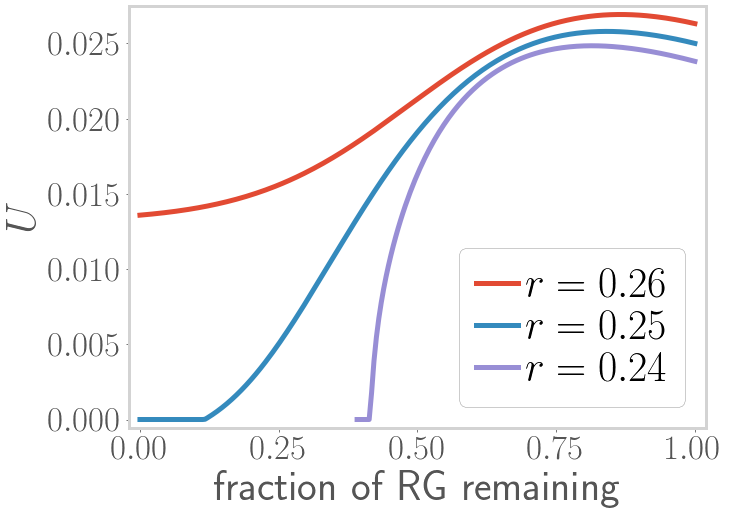

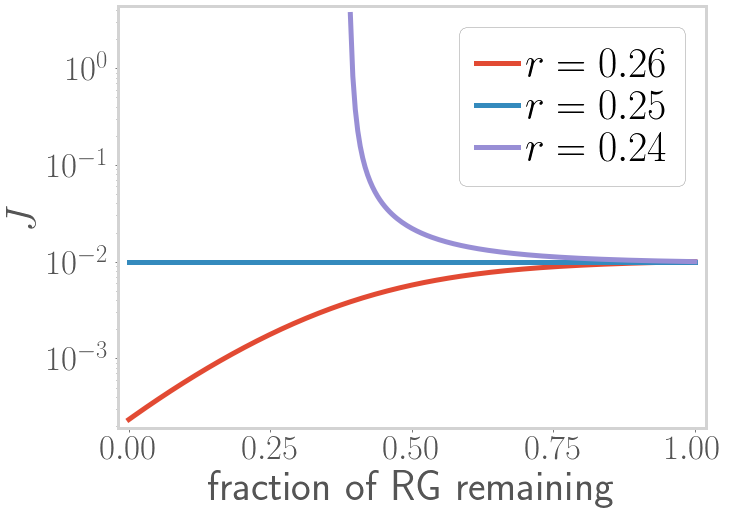

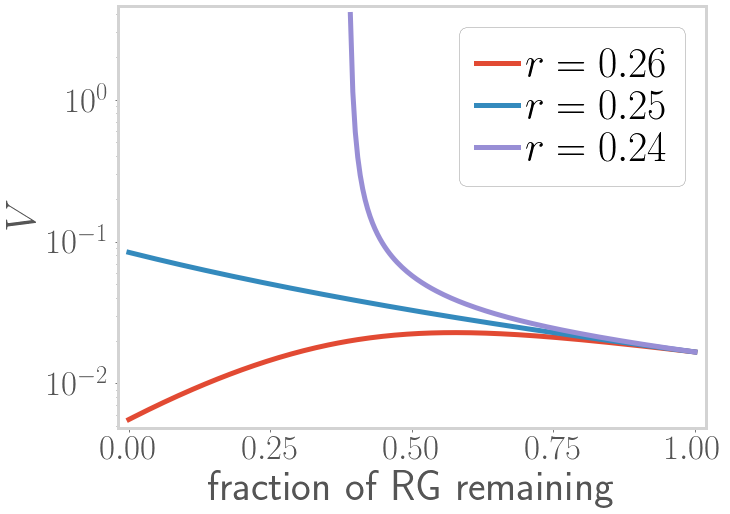

In [284]:
def plot_rgflows_Ub():
    D0 = 11.5
    w = -D0/2
    V0 = D0/60
    J0 = D0/100
    
    U0_range = 10 * J0 / np.linspace(3.8, 4.2, 3)
    figs = [plt.subplots() for i in range(3)]
    for U0 in U0_range:
        E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=-U0/10)
        steps = E/D0
        label = r"$r={:.2f}$".format(0.1*U0/J0)
        figs[0][1].plot(steps, U/D0, label=label)
        figs[1][1].plot(steps, J/D0, label=label)
        figs[2][1].plot(steps, V/D0, label=label)
    
    
    for (fig, ax), name in zip(figs, ["U","J","V"]):
        ax.set_xlabel(r"fraction of RG remaining")
        ax.set_ylabel(r"${}$".format(name))
        if name != "U": ax.set_yscale("log")
        ax.legend()
        fig.savefig(name+"_Ub.pdf", bbox_inches='tight')
        fig.show()

plot_rgflows_Ub()

## $J^*/V^*$ vs $D_0$

  0%|          | 0/5 [00:00<?, ?it/s]

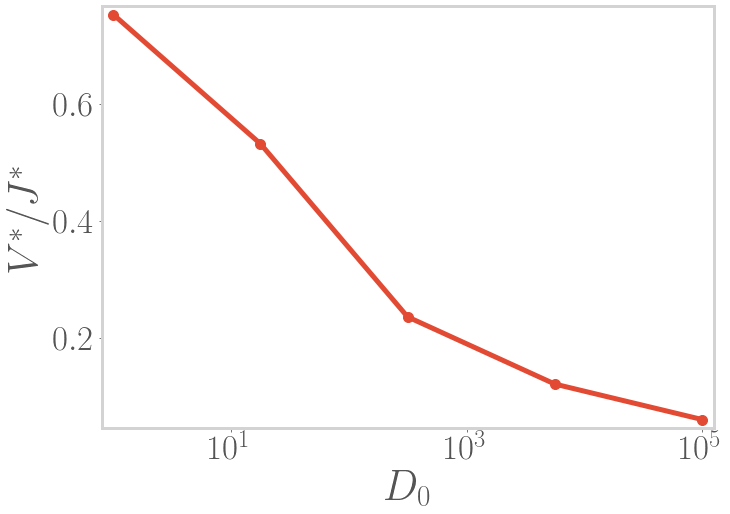

In [285]:
def plot_J_by_V_vs_D_Ub():
    D0 = 10
    U0 = D0/50
    V0 = D0/100
    J0 = D0/100
    
    D0_range = 10**np.linspace(0, 5, 5)
    y = []
    for D0 in tqdm(D0_range):
        w = -D0/2
        try:
            yi = np.load("J_bandwidth-D0={:.5f},U0={:.5f},V0={:.5f},J0={:.5f},w={:.5f}.npy".format(D0,U0,V0,J0,w))
        except:
            E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=-U0/10)
            steps = E/D0
            yi = V[-1]/J[-1]
            np.save("J_bandwidth-D0={:.5f},U0={:.5f},V0={:.5f},J0={:.5f},w={:.5f}.npy".format(D0,U0,V0,J0,w), yi)
        y.append(yi)
    
    plt.plot(D0_range, y, marker="o")
    plt.xlabel(r"$D_0$")
    plt.ylabel(r"$V^*/J^*$")
    plt.xscale("log")
    plt.savefig("J_bandwidth.pdf", bbox_inches='tight')
    plt.show()
    
plot_J_by_V_vs_D_Ub()

## **Phase map for MIT**

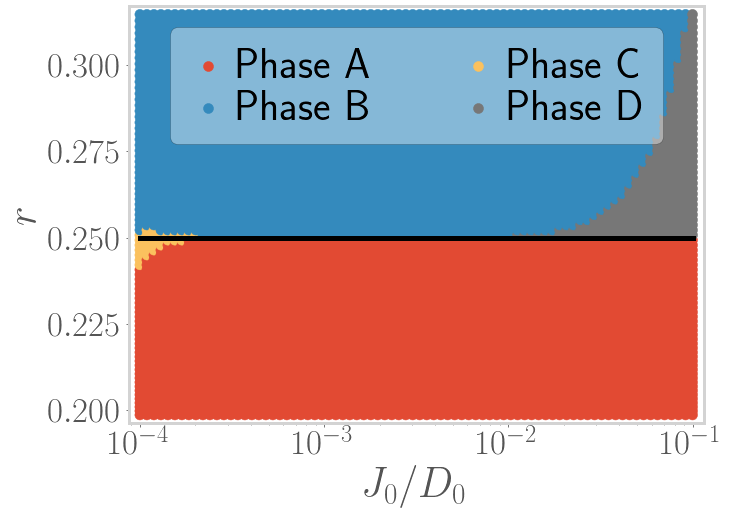

In [286]:
def get_Uc(args):
    (J0, V0, Ub_range), (w, D0, N, cols) = args
    colors = []
    for Ub in Ub_range:
        E, U, V, J = complete_RG(w, D0, -10*Ub, V0, J0, Ub=Ub)
        u = np.round(U, 6)[-1]
        j = np.round(J, 6)[-1]
        v = np.round(V, 6)[-1]
        if u == 0 and v == 0 and j == 0:
            colors.append(cols[3])
        elif u < j:
            colors.append(cols[0])
        elif u > v and u > j:
            colors.append(cols[1])
        elif u < v and u > j:
            colors.append(cols[2])
        else:
            colors.append(cols[4])
            print (U0,u,V0,v,J0,j)
    return colors, Ub_range
    
    
def get_phasemap():
    cols[2] = cols[4]
    D0 = 600
    w = -D0/2
    J0_range = (D0) * 10**np.linspace(-4, -1, 80)
    Ubmax = 0.1
    Ubmin = -0.1
    Ub_range = [-(J0/4) * 10**np.linspace(Ubmin, Ubmax, len(J0_range)) for J0 in J0_range]
    V0_range = 2*J0_range
    fname = "phase-D0={:.5f},w={:.5f},Ub={:.5f},{:.5f},J0={:.5f},{:.5f},{:.0f},\
    V0={:.5f},{:.5f},{:.0f}.npy".format(D0,w,Ubmin,Ubmax,J0_range[0],J0_range[-1],len(J0_range),
                                       V0_range[0],V0_range[-1],len(V0_range))
    try:
        Uc = np.load(fname)
    except:
        args = product(zip(J0_range, V0_range, Ub_range), [(w, D0, len(J0_range), cols)])
        Uc = list(tqdm(Pool(30).imap(get_Uc, args), total=len(J0_range)))
    np.save(fname, Uc)
    for J0, (colors, Ub_range) in zip(J0_range, Uc):
        Ub_range = np.array([float(Ub) for Ub in Ub_range])
        plt.scatter(J0*np.ones_like(Ub_range)/D0, -Ub_range/J0, color=colors)
    
    plt.plot(J0_range/D0, np.ones_like(J0_range)/4, color='black')
    plt.scatter([], [], color=cols[0], label=r"Phase A")
    plt.scatter([], [], color=cols[1], label=r"Phase B")
    plt.scatter([], [], color=cols[2], label=r"Phase C")
    plt.scatter([], [], color=cols[3], label=r"Phase D")
    plt.xscale("log")
    plt.xlabel(r"$J_0/D_0$")
    plt.ylabel(r"$r$")
    plt.legend(ncol=2, loc="upper center")
    
    plt.savefig("phase-map-MIT.pdf", bbox_inches='tight')
    plt.show()
    
get_phasemap()

## Evolution of overlaps and correlations

  0%|          | 0/300 [00:00<?, ?it/s]

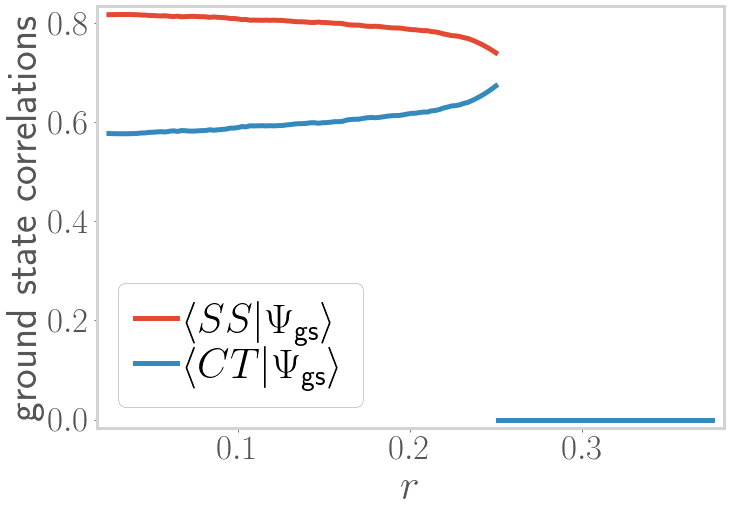

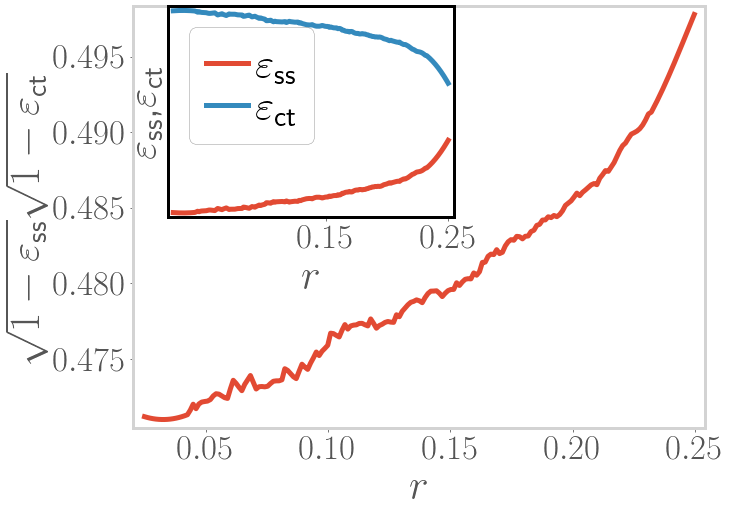

In [368]:
def get_corr(args):
    Ub,(w,D0,V0,J0,total_dim,spin_singlet,charge_triplet_zero,lm,Sz_d,Cz_b) = args
    U0 = -10*Ub
    E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
    u,v,j = [(0 if a[-1] < a[0]/100 else a[-1]) for a in (U,V,J)]
    t = 1
    filename = "t={:.5f},tdim={:.0f},U={:.5f},Ub={:.5f},V={:.5f},J={:.5f}".format(t,total_dim,u,Ub,v,j)
    try:
        E = qload("./corr-EX/E-"+filename)
        X = qload("./corr-EX/X-"+filename)
    except:
        H = get_full_ham(t, int((total_dim - 2)/2), u, v, j, Ubath=Ub)
        E, X = H.eigenstates()
        qsave(E, "./corr-EX/E-"+filename)
        qsave(X, "./corr-EX/X-"+filename)

    E = np.round(E, 5)
    C1,C2 = 0,0
    deg = len(X[E == min(E)])
    for Xgs in X[E == min(E)]:
        C1 += np.abs((Xgs.dag() * spin_singlet)[0][0][0]) / deg
        C2 += np.abs((Xgs.dag() * charge_triplet_zero)[0][0][0]) / deg
    return C1,C2

        
def track_wf():
    D0 = 500
    Ub_min_arr = [-0.2, -0.3, -0.03]
    Ub_max_arr = [0.2, 0.2, 0.06]
    total_dim = 2*(1+1)
    w = -D0/2
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i -1)) for i in range(total_dim)]
    chain = tensor([basis(2,0)]*total_dim)
    for i in range(total_dim-4):
        chain = (1 + c_all[total_dim-1-i].dag()) * chain

    spin_singlet = ((c_all[0].dag()*c_all[3].dag() - c_all[1].dag()*c_all[2].dag())*chain).unit()
    charge_triplet_zero = ((c_all[0].dag()*c_all[1].dag() + c_all[2].dag()*c_all[3].dag())*chain).unit()
    lm = ((c_all[0].dag() + c_all[1].dag())*(1 + c_all[2].dag())*(1 + c_all[3].dag())*chain).unit()
    Sz_d = 0.5 * (c_all[0].dag()*c_all[0] - c_all[1].dag()*c_all[1])
    Cz_b = 0.5 * (c_all[2].dag()*c_all[2] + c_all[3].dag()*c_all[3] - 1)
    
    J0 = D0*10**(-2)
    Ub_max = 1.5
    Ub_min = 0.1
    N_U = 300
        
    V0 = J0*2
    Ub_range = -(J0/4)*np.linspace(Ub_min, Ub_max, N_U)

    x = -Ub_range/J0
    args = product(Ub_range,[[w,D0,V0,J0,total_dim,spin_singlet,charge_triplet_zero,lm,Sz_d,Cz_b]])
    C = [[] for i in range(2)]
    Cs = list(tqdm(Pool(20).imap(get_corr, args), total=len(Ub_range)))
    for c0,c1 in Cs:
        C[0].append(c0)
        C[1].append(c1)

    C = [np.array(c) for c in C]
    force = 31
    best_fit_SS1 = np.array(savgol_filter(C[0][x<0.25], force, 2))
    best_fit_CT1 = np.array(savgol_filter(C[1][x<0.25], force, 2))
    best_fit_SS2 = np.array(C[0][x>0.25])
    best_fit_CT2 = np.array(C[1][x>0.25])
    
    xi_SS = 1 - best_fit_SS1**2
    xi_CT = 1 - best_fit_CT1**2
    cross_term = np.sqrt(1 - xi_SS) * np.sqrt(1 - xi_CT)

    plt.plot(x[x<0.25][::2], best_fit_SS1[::2], label=r"$\braket{SS|\Psi_\text{gs}}$")
    plt.plot(x[x<0.25][::2], best_fit_CT1[::2], label=r"$\braket{CT|\Psi_\text{gs}}$")
    plt.plot(x[x>0.25][::2], best_fit_SS2[::2], color=cols[0])
    plt.plot(x[x>0.25][::2], best_fit_CT2[::2], color=cols[1])
    plt.xlabel(r"$r$")
    plt.ylabel(r"ground state correlations")
    plt.legend()
    plt.savefig("corrs_gs.pdf", bbox_inches='tight')
    plt.show()
    
    plt.plot(x[x<0.25], cross_term)
    plt.xlabel(r"$r$")
    plt.ylabel(r"$\sqrt{1 - \varepsilon_\text{ss}}\sqrt{1 - \varepsilon_\text{ct}}$")
    ins = plt.gca().inset_axes([0.06,0.5,0.5,0.5])
    ins.set_yticks([])
    ins.set_xticks(np.arange(0.15,0.26,0.1))
    ins.plot(x[x<0.25], xi_SS, label=r"$\varepsilon_\text{ss}$")
    ins.plot(x[x<0.25], xi_CT, label=r"$\varepsilon_\text{ct}$")
    ins.set_ylabel(r"$\varepsilon_\text{ss}$,$\varepsilon_\text{ct}$")
    ins.set_xlabel(r"$r$")
    ins.legend()
    [ins.spines[key].set_linewidth(3) for key in ins.spines.keys()]
    [ins.spines[key].set_color("black") for key in ins.spines.keys()]
    plt.savefig("entanglement.pdf", bbox_inches='tight')
    plt.show()

track_wf()

## Spectral function

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

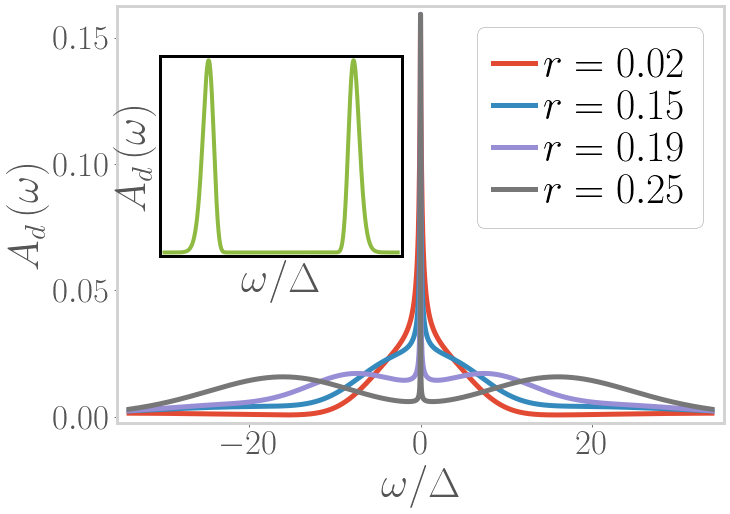

In [288]:
def spec_func_ms():
    
    
    delta = 1
    rho0 = 0.1
    t = 15
    Nk = 4
    a = 1
    k_bath = 2*np.pi*np.linspace(0, Nk-1, Nk)/(a*Nk)
    Ek_0 = np.round(-2*t*np.cos(k_bath*a), 2)
    V = round(np.sqrt(delta/(np.pi * rho0)), 2)
    non_int_ht = 1/(2*np.pi*delta)
    N_w = 2000
    w_cut = delta*0.5
    U_range = np.array([0.1, 8, 15, 30])#np.linspace(0.5, 30, 3)
    J_range = np.array([0.5, 5.5, 8, 30*4/10])#np.linspace(0.5, 30*4/10, 3)
    w_max = 7*delta + max(U_range)*0.9
    for U,J in tqdm(zip(U_range, J_range), total=len(U_range)):
        Ub = -U/10
        w_range = np.linspace(-w_max, w_max, N_w)*delta
        w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
        fname = "sf-Nk={:.0f},w={:.5f},{:.5f},{:.0f},U={:.5f},J={:.5f},V={:.5f},delta={:.5f},\
        t={:.5f}.npy".format(Nk,w_range[0],w_range[-1],len(w_range),U,V,J,delta,t)
        try:
            A = np.load(fname)
        except:
            A = spec_func_U((Ek_0, U, V, J), delta, w_range, non_int_ht, Ubath=Ub)
        np.save(fname, A)
        plt.plot(w_range, A, label=r'$r={:.2f}$'.format(-Ub/J))

    ins = plt.gca().inset_axes([0.07,0.4,0.4,0.48])
    ins.set_xticks([])
    ins.set_yticks([])
    ins.set_ylabel(r"$A_d\left(\omega\right)$")
    ins.set_xlabel(r"$\omega/\Delta$")
    U = 31
    w_max = U*0.8
    N_w = 2000
    w_range = np.linspace(-w_max, w_max, N_w)
    w_range = np.insert(w_range, int(len(w_range)/2), 0) if 0 not in w_range else w_range
    H = get_ham_K([0], -U/2, U, 0, 0)
    E, X = H.eigenstates()
    X0 = X[np.where(E == min(E))]
    total_dim = len(X[0].dims[0])
    c_all = [tensor([sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(4 - i -1)) for i in range(4)]
    O_up = c_all[0]
    Z = len(X0)
    A = 0
    for En, Xn in tqdm(zip(E, X), total=len(E)):
        for Xgs in X0:
            C1 = Xgs.dag()*O_up*Xn
            C1_sq = np.real((C1*C1.dag())[0][0][0])
            C2 = Xn.dag()*O_up*Xgs
            C2_sq = np.real((C2*C2.dag())[0][0][0])
            eta = 0.1 + 0.1 * np.abs(w_range)
            x1 = w_range + E[0] - En
            x2 = w_range + En - E[0]
            A += (C1_sq * np.exp(-(x1/eta)**2)/(eta*sqrt(np.pi)) + C2_sq * np.exp(-(x2/eta)**2)/(eta*sqrt(np.pi))) / Z
            A /= Z

    A = 0.5*(A + np.flip(A))
    ins.plot(w_range, A, color=cols[5], lw=4)
    [ins.spines[key].set_linewidth(3) for key in ins.spines.keys()]
    [ins.spines[key].set_color("black") for key in ins.spines.keys()]

    plt.xlabel(r"$\omega/\Delta$")
    plt.ylabel(r"$A_d\left(\omega\right)$")
    plt.legend()
    plt.savefig("Add.pdf", bbox_inches='tight')
    plt.show()

spec_func_ms()

## Correlations across the transition

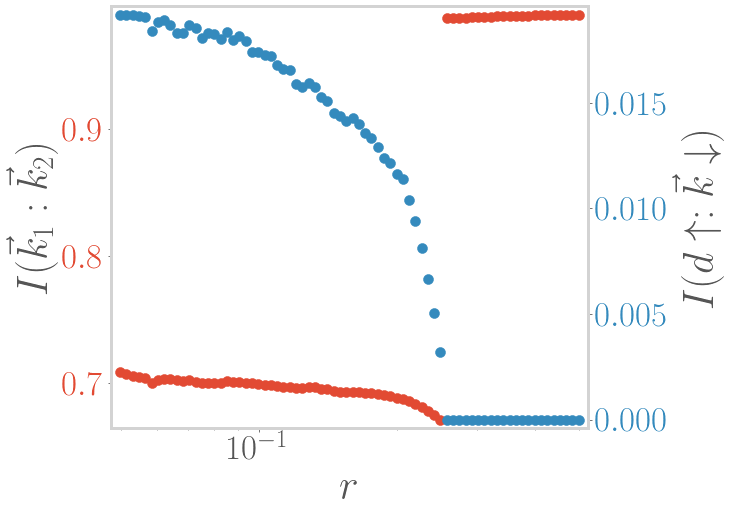

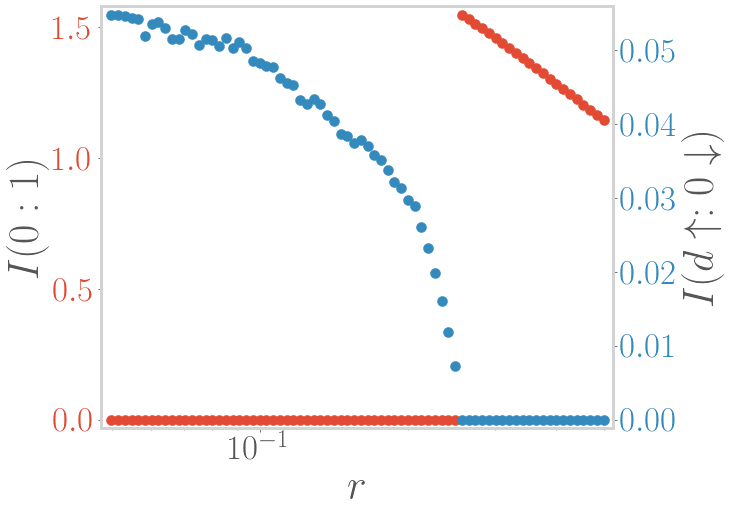

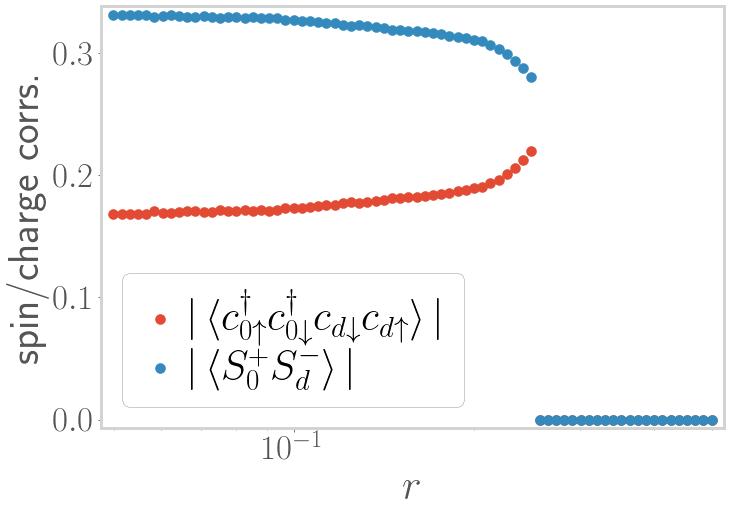

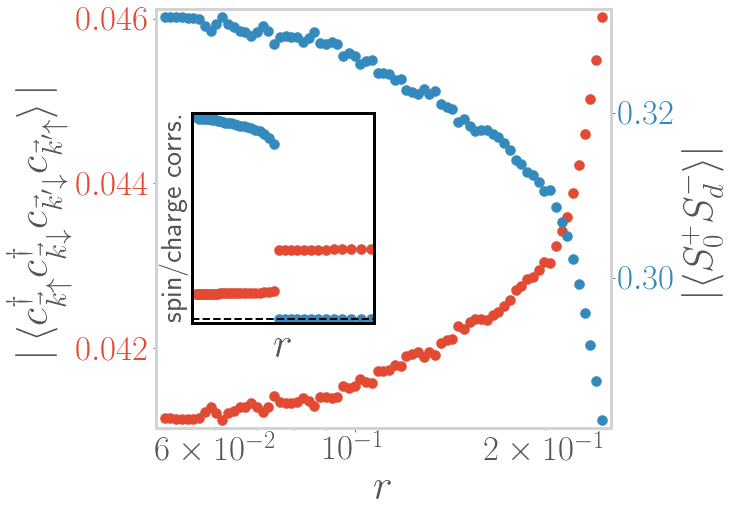

In [289]:
def pool_func(args):
    Ub, (dim, t, D0, V0, J0) = args
    U0 = -10*Ub
    w = -D0/2
    E, U, V, J = complete_RG(w, D0, U0, V0, J0, Ub=Ub)
    U,V,J = [(0 if a[-1] < a[0]/100 else a[-1]) for a in (U,V,J)]
    Ek_0 = 2*t*np.linspace(-1, 1, dim)
    H_r = get_full_ham(t, dim, U, V, J, Ubath=Ub)
    H_k = get_ham_K(Ek_0, -U/2, U, V, J, Ubath=Ub)
    E, X = H_r.eigenstates()
    E = np.round(E, 5)
    Xgs_r_all = [X[i] for i,Ei in enumerate(E) if Ei == min(E)]
    E, X = H_k.eigenstates()
    E = np.round(E, 5)
    Xgs_k_all = [X[i] for i,Ei in enumerate(E) if Ei == min(E)]
    I_k1k2 = sum([get_MI(Xgs_k, [2,3], [4,5]) for Xgs_k in Xgs_k_all])/len(Xgs_k_all)
    I_du_kd = sum([get_MI(Xgs_k,[0],[3]) for Xgs_k in Xgs_k_all])/len(Xgs_k_all)
    I_01 = sum([get_MI(Xgs_r,[2,3],[4,5]) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
    I_du_0d = sum([get_MI(Xgs_r,[0],[3]) for Xgs_r in Xgs_r_all])/len(Xgs_r_all)
    corr_charge = abs(sum([get_charge_corr(Xgs_k, (2,3,5,4)) for Xgs_k in Xgs_k_all])/len(Xgs_k_all))
    corr_spin = abs(sum([get_spin_corr(Xgs_r, (0,1,3,2)) for Xgs_r in Xgs_r_all])/len(Xgs_r_all))
    corr_charge_d0 = abs(sum([get_charge_corr(Xgs_r, (2,3,1,0)) for Xgs_r in Xgs_r_all])/len(Xgs_r_all))

    return I_k1k2,I_du_kd,I_01,I_du_0d,corr_charge_d0,corr_spin,corr_charge,corr_spin


def get_measures():
    D0 = 1000
    t = 1
    dim = 4
    J0 = D0/100
    Ubath_ = (-J0/4) * 10**np.linspace(-0.7, 0.3, 220)
    V0 = 2*J0
    fname= "measures-D0={:.5f},t={:.5f},J0={:.5f},V0={:.5f},Ub={:.5f},{:.5f}\
    ,{:.0f}.npy".format(D0, t, J0, V0, Ubath_[0], Ubath_[-1], len(Ubath_))
    try:        
        results = np.load(fname)
    except:
        args = product(Ubath_, [(dim, t, D0, V0, J0)])
        results = list(tqdm(Pool(10).imap(pool_func, args), total=len(Ubath_)))
    np.save(fname, results)
    y = [[result[i] for result in results] for i in range(len(results[0]))] 
    force = 27
    for i, yi in enumerate(y):
        y[i] = np.array(y[i])
        y[i][-Ubath_/J0 < 0.25] = savgol_filter(y[i][-Ubath_/J0 < 0.25], force, 2)
   
    ylabels = [r"$I(\vec k_1:\vec k_2)$", r"$I(d\uparrow:\vec k\downarrow)$",
               r"$I(0:1)$", r"$I(d\uparrow:0\downarrow)$",
               r"$|\braket{c^\dagger_{0 \uparrow} c^\dagger_{0 \downarrow} c_{d \downarrow} c_{d \uparrow}}|$", 
               r"$|\braket{S_0^+ S_d^-}|$",
               r"$|\braket{c^\dagger_{\vec k \uparrow} c^\dagger_{\vec k \downarrow} c_{\vec k^\prime \downarrow} c_{\vec k^\prime \uparrow}}|$", 
               r"$|\langle S_0^+ S_d^- \rangle|$"]
    saves = ["I_k.pdf", "I_r.pdf", "odlro_d0.pdf", "odlro.pdf"]
    
    x = -Ubath_[::3]/J0
    for i in range(0, len(ylabels)-4, 2):
        y1 = y[i][::3]
        y2 = y[i+1][::3]
        plt.scatter(x, y1)
        plt.xlabel(r"$r$")
        plt.ylabel(ylabels[i])
        plt.xscale("log")
        plt.gca().tick_params(axis='y', labelcolor=cols[0])
        ax = plt.gca().twinx()
        ax.scatter(x, y2, color=cols[1])
        ax.set_ylabel(ylabels[i+1])
        ax.tick_params(axis='y', labelcolor=cols[1])
        plt.savefig(saves[int(i/2)], bbox_inches='tight')
        plt.show()
        
    i = 4
    x = -Ubath_[::3]/J0
    y1 = y[i][::3]
    y2 = y[i+1][::3]
    plt.scatter(x, y1, label=ylabels[i])
    plt.scatter(x, y2, label=ylabels[i+1])
    plt.xlabel(r"$r$")
    plt.ylabel(r"spin/charge corrs.")
    plt.xscale("log")
    plt.legend()
    plt.savefig(saves[int(i/2)], bbox_inches='tight')
    plt.show()
        
    i = 6
    x = -Ubath_[-Ubath_/J0 < 0.25][::2]/J0
    y1 = y[i][-Ubath_/J0 < 0.25][::2]
    y2 = y[i+1][-Ubath_/J0 < 0.25][::2]
    plt.scatter(x, y1)
    plt.xlabel(r"$r$")
    plt.ylabel(ylabels[i])
    plt.xscale("log")
    plt.gca().tick_params(axis='y', labelcolor=cols[0])
    ax = plt.gca().twinx()
    ax.scatter(x, y2, color=cols[1])
    ax.set_ylabel(ylabels[i+1])
    ax.tick_params(axis='y', labelcolor=cols[1])
    ins = plt.gca().inset_axes([0.08,0.25,0.4,0.5])
    ins.scatter(-Ubath_[::5]/J0, y[i][::5])
    ins.scatter(-Ubath_[::5]/J0, y[i+1][::5])
    ins.set_xlabel(r"$r$")
    ins.set_ylabel(r"spin/charge corrs.", size=30)
    ins.set_yticks([])
    ins.set_xticks([])
    [ins.spines[key].set_linewidth(3) for key in ins.spines.keys()]
    [ins.spines[key].set_color("black") for key in ins.spines.keys()]
    ins.axhline(0,0,1,ls="--", lw=2, color='black')
    plt.savefig(saves[int(i/2)], bbox_inches='tight')
    plt.show()

get_measures()